In [1]:
from sympy import *
from sympy.physics.mechanics import *
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib import animation

init_vprinting()

In [2]:
m1, m2, m3, l1, l2, l3, g, t, tau1, tau2, tau3 = symbols('m1 m2 m3 l1 l2 l3 g t tau1 tau2 tau3')
theta1, theta2, theta3 = dynamicsymbols('theta1 theta2 theta3')

p1 = Matrix([[l1*sin(theta1)], [-l1*cos(theta1)]])
p2 = p1 + Matrix([[l2*sin(theta2)], [-l2*cos(theta2)]])
p3 = p1 + Matrix([[l3*sin(theta3)], [-l3*cos(theta3)]])

dp1 = Matrix([[diff(p1, theta1), diff(p1, theta2), diff(p1, theta3)]])
dp2 = Matrix([[diff(p2, theta1), diff(p2, theta2), diff(p2, theta3)]])
dp3 = Matrix([[diff(p3, theta1), diff(p3, theta2), diff(p3, theta3)]])

theta1_dot = diff(theta1, t)
theta2_dot = diff(theta2, t)
theta3_dot = diff(theta3, t)
theta1_ddot = diff(theta1_dot, t)
theta2_ddot = diff(theta2_dot, t)
theta3_ddot = diff(theta3_dot, t)

theta = Matrix([[theta1], [theta2], [theta3]])
theta_dot = Matrix([[theta1_dot], [theta2_dot], [theta3_dot]])
theta_ddot = Matrix([[theta1_ddot], [theta2_ddot], [theta3_ddot]])

In [3]:
U = m1*g*p1[1] + m2*g*p2[1] + m3*g*p3[1]
K = (1/2*(m1*theta_dot.T*dp1.T*dp1*theta_dot + m2*theta_dot.T*dp2.T*dp2*theta_dot + m3*theta_dot.T*dp3.T*dp3*theta_dot))[0]
L = K - U

eqn1 = diff(diff(L, theta1_dot), t) - diff(L, theta1)
eqn2 = diff(diff(L, theta2_dot), t) - diff(L, theta2)
eqn3 = diff(diff(L, theta3_dot), t) - diff(L, theta3)

eqn = simplify(Matrix([[eqn1], [eqn2], [eqn3]]))

In [5]:
M = simplify(m1*dp1.T*dp1 + m2*dp2.T*dp2 + m3*dp3.T*dp3)
N = simplify(eqn - M*theta_ddot)
M_inv = M.inv()
M, N

⎛⎡   2                                                               ⎤  ⎡     
⎜⎢ l₁ ⋅(m₁ + m₂ + m₃)    l₁⋅l₂⋅m₂⋅cos(θ₁ - θ₂)  l₁⋅l₃⋅m₃⋅cos(θ₁ - θ₃)⎥  ⎢1.0⋅l
⎜⎢                                                                   ⎥  ⎢     
⎜⎢                                2                                  ⎥  ⎢     
⎜⎢l₁⋅l₂⋅m₂⋅cos(θ₁ - θ₂)         l₂ ⋅m₂                    0          ⎥, ⎢     
⎜⎢                                                                   ⎥  ⎢     
⎜⎢                                                       2           ⎥  ⎢     
⎝⎣l₁⋅l₃⋅m₃⋅cos(θ₁ - θ₃)            0                   l₃ ⋅m₃        ⎦  ⎣     

  ⎛                                                                  2        
₁⋅⎝g⋅m₁⋅sin(θ₁) + g⋅m₂⋅sin(θ₁) + g⋅m₃⋅sin(θ₁) + l₂⋅m₂⋅sin(θ₁ - θ₂)⋅θ₂̇  + l₃⋅m
                                                                              
                                  ⎛                              2⎞           
                        1.0⋅l₂⋅m₂⋅⎝g⋅sin(θ₂) - l₁⋅s

In [6]:
tau = Matrix([[tau1], [tau2], [tau3]])
theta_ddot_sym = M_inv*(tau - N)
theta1_ddot_expr = lambdify((m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau1, tau2, tau3), theta_ddot_sym[0], modules='numpy')
theta2_ddot_expr = lambdify((m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau1, tau2, tau3), theta_ddot_sym[1], modules='numpy')
theta3_ddot_expr = lambdify((m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau1, tau2, tau3), theta_ddot_sym[2], modules='numpy')

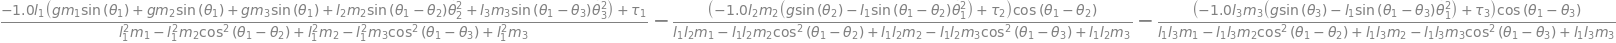

In [7]:
theta_ddot_sym[0]

In [8]:
Lp = M.adjugate().cholesky(hermitian=False)
L = Lp/sqrt(M.det())
L_inv = Lp.adjugate()/(Lp.det()*sqrt(M.det()))

M_bar = L_inv[1:3, 1:3]
N_bar = L.T[1:3, 1:3]*N[1:3, 0] - L_inv[1:3, 0]/L_inv[0, 0]*(L.T[0, 0]*N[0, 0] + (L.T[0, 1:3]*N[1:3, 0])[0])
B_bar = -L.T[0, 0]/L_inv[0, 0]*L_inv[1:3, 0]
#M_bar, N_bar, B_bar

In [9]:
#e = Matrix([[theta1], [theta2-pi/2], [theta3+pi/2]])
#e_dot = Matrix([[theta1_dot], [theta2_dot], [theta3_dot]])
#tau1_sym = M*(-e-e_dot)+N
#tau1_expr = lambdify((m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot), tau1_sym[0], modules='numpy')
#tau2_expr = lambdify((m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot), tau1_sym[1], modules='numpy')
#tau3_expr = lambdify((m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot), tau1_sym[2], modules='numpy')

K1 = 1
K2 = 1
e = theta2-theta3
e_dot = theta2_dot-theta3_dot
e_ddot = -K1*e-K2*e_dot
tau1_sym = 1/(B_bar[0, 0]/M_bar[0, 0] - B_bar[1, 0]/M_bar[1, 1])*(e_ddot + N_bar[0, 0]/M_bar[0, 0] - N_bar[1, 0]/M_bar[1, 1])
tau1_expr = lambdify((m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot), tau1_sym, modules='numpy')

In [10]:
(B_bar[0, 0]/M_bar[0, 0] - B_bar[1, 0]/M_bar[1, 1])

In [60]:
m1 = 1
m2 = 200
m3 = 100
l1 = 100
l2 = 4
l3 = 5
g = 9.81

dt = 0.001
tf = 10
t = np.arange(0, tf, dt)

theta1_0 = np.pi/4
theta2_0 = 0
theta3_0 = 0.01
theta1_dot_0 = 0
theta2_dot_0 = 0
theta3_dot_0 = 0

def ODE(t, y):
    theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot = y
    tau1 = tau1_expr(m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot)
    tau2 = 0
    tau3 = 0
    theta1_ddot = theta1_ddot_expr(m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau1, tau2, tau3)
    theta2_ddot = theta2_ddot_expr(m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau1, tau2, tau3)
    theta3_ddot = theta3_ddot_expr(m1, m2, m3, l1, l2, l3, g, theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot, tau1, tau2, tau3)
    return (theta1_dot, theta2_dot, theta3_dot, theta1_ddot, theta2_ddot, theta3_ddot)

sol = solve_ivp(ODE, (0, tf), (theta1_0, theta2_0, theta3_0, theta1_dot_0, theta2_dot_0, theta3_dot_0), t_eval=t, method='DOP853', rtol=1e-6, atol=1e-6)
theta1, theta2, theta3, theta1_dot, theta2_dot, theta3_dot = sol.y

print(t.shape, theta1.shape)
assert(t.shape == theta1.shape)

(10000,) (3081,)


AssertionError: 

In [45]:
total_energy_arr = np.zeros(len(t))
for i in range(len(t)):
    total_energy_arr[i] = total_energy(m1, m2, m3, l1, l2, l3, g, theta1[i], theta2[i], theta3[i], theta1_dot[i], theta2_dot[i], theta3_dot[i])
total_energy_arr

IndexError: index 1827 is out of bounds for axis 0 with size 1827

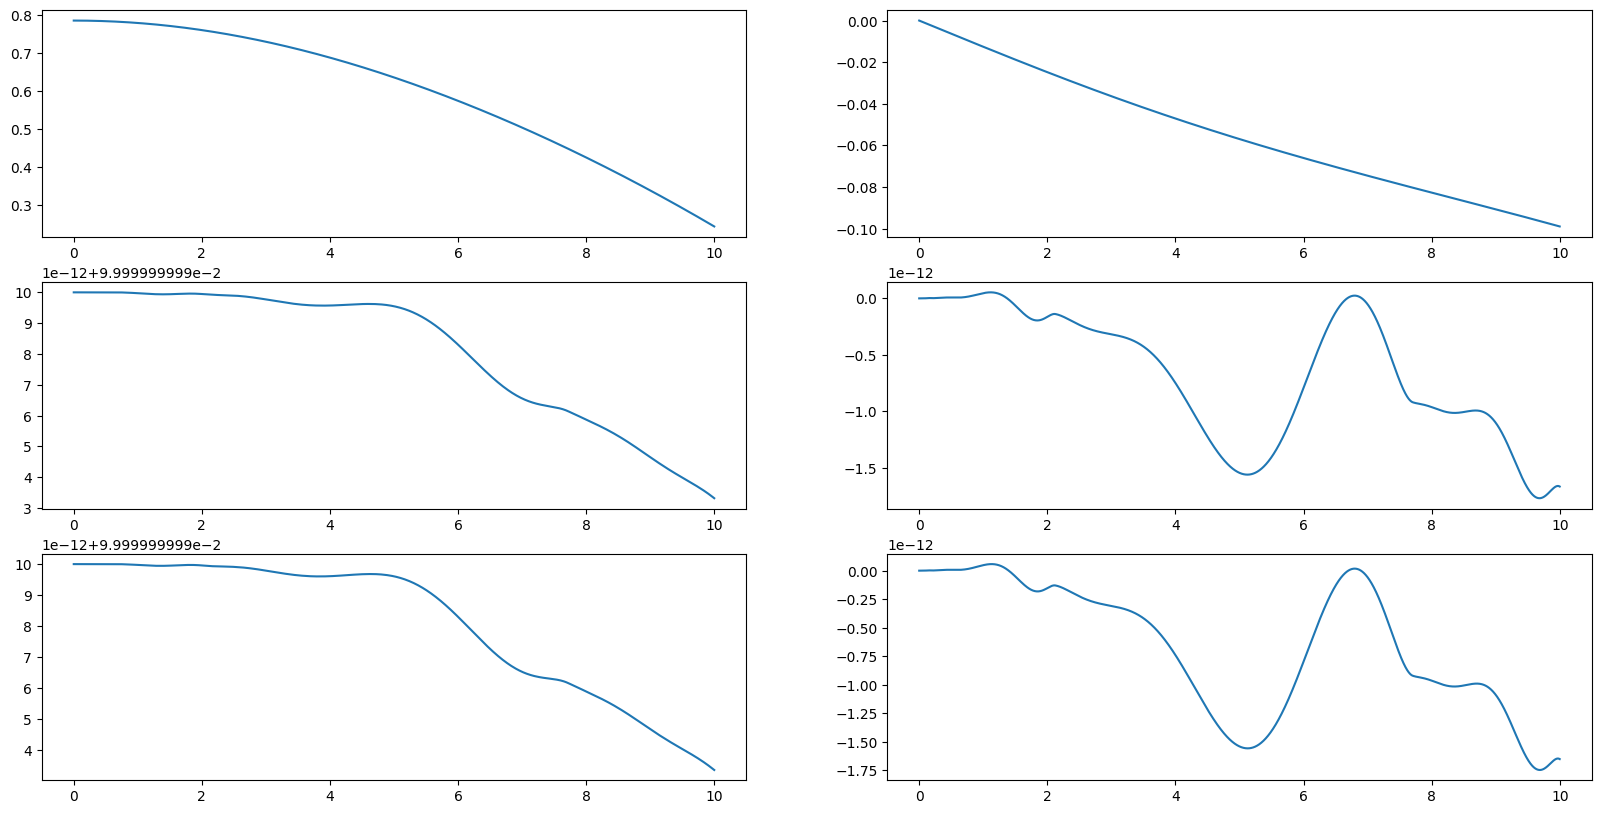

In [54]:
plt.figure(figsize=(20, 10))
plt.subplot(3, 2, 1)
plt.plot(t, theta1, label=r'$\theta_1$')
plt.subplot(3, 2, 3)
plt.plot(t, theta2, label=r'$\theta_2$')
plt.subplot(3, 2, 5)
plt.plot(t, theta3, label=r'$\theta_3$')

plt.subplot(3, 2, 2)
plt.plot(t, theta1_dot, label=r'$\dot{\theta}_1$')
plt.subplot(3, 2, 4)
plt.plot(t, theta2_dot, label=r'$\dot{\theta}_2$')
plt.subplot(3, 2, 6)
plt.plot(t, theta3_dot, label=r'$\dot{\theta}_3$')

In [31]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-3, 3), ylim=(-3, 3), aspect='equal')
ax.grid()

# Plot initial position
line1 = ax.plot([0, l1*np.sin(theta1[0])], [0, -l1*np.cos(theta1[0])], 'o-', lw=2)[0]
line2 = ax.plot([l1*np.sin(theta1[0]), l1*np.sin(theta1[0])+l2*np.sin(theta2[0])], [-l1*np.cos(theta1[0]), -l1*np.cos(theta1[0])-l2*np.cos(theta2[0])], 'o-', lw=2)[0]
line3 = ax.plot([l1*np.sin(theta1[0]), l1*np.sin(theta1[0])+l3*np.sin(theta3[0])], [-l1*np.cos(theta1[0]), -l1*np.cos(theta1[0])-l3*np.cos(theta3[0])], 'o-', lw=2)[0]

# Text box for time and torque
#text = ax.text(0.05, 0.9, f'time: {t[0]:.1f} s\ntau: {tau[0]:.1f} Nm', transform=ax.transAxes, bbox=dict(facecolor='white', alpha=0.5), fontsize=18)

fps = 30
def animate(i):
    i = int(i/(fps*dt))
    line1.set_data([0, l1*np.sin(theta1[i])], [0, -l1*np.cos(theta1[i])])
    line2.set_data([l1*np.sin(theta1[i]), l1*np.sin(theta1[i])+l2*np.sin(theta2[i])], [-l1*np.cos(theta1[i]), -l1*np.cos(theta1[i])-l2*np.cos(theta2[i])])
    line3.set_data([l1*np.sin(theta1[i]), l1*np.sin(theta1[i])+l3*np.sin(theta3[i])], [-l1*np.cos(theta1[i]), -l1*np.cos(theta1[i])-l3*np.cos(theta3[i])])
    #text.set_text(f'time: {t[i]:.1f} s\ntau: {tau[i]:.1f} Nm')

tf_sim = tf
ani = animation.FuncAnimation(fig, animate, frames=fps*tf_sim)
ffmpeg_writer = animation.FFMpegWriter(fps=fps)
ani.save(f'double_double.mp4', writer=ffmpeg_writer)
plt.close(fig)